In [2]:
#####################################################################################################################
#  Time Series Prediction of Stock Prices using Recurrent Neural Network
#  Jesper S. Bajwa
#####################################################################################################################

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

dataFile = 'https://raw.githubusercontent.com/JSB-0/RNN_4375/main/APPL_1980_2021_Stock_Data.csv'

In [3]:
original_df = pd.read_csv(dataFile, parse_dates = True, index_col = 0) # read the file

In [4]:
# Displays our original data
original_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600
...,...,...,...,...,...,...
2022-06-13,132.869995,135.199997,131.440002,131.880005,131.880005,122207100
2022-06-14,133.130005,133.889999,131.479996,132.759995,132.759995,84784300
2022-06-15,134.289993,137.339996,132.160004,135.429993,135.429993,91533000


In [5]:
#-----------------------------Drop Unnecessary Columns and Normalaize-------------------------------------
# pre-processing dataset
#   -We removed null entries that did not have complete data
#   -There are no redundant columns that need to be removed
#   -We removed unnecessary columns Date, Open, High, Low, Close, and Volume


# Remove any entries that do not have complete data
df_clean = original_df.dropna(axis = 'rows', how = 'any')

# Remove unnecessary columns
df_clean = df_clean.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])

In [6]:
# ---Splitting Data on Time Period---
# Here we separate the data into training and validation sets
# We will use data from 1980 - 2015 for training and validate on 2016-2019
# We will be doing this to avoid the initial market crash due to the pandemic

data_train_dates = df_clean.loc['1980':'2015', 'Adj Close']
data_val_dates = df_clean.loc['2016':'2019', 'Adj Close']

In [ ]:
data_train_dates

Date
1980-12-12     0.100178
1980-12-15     0.094952
1980-12-16     0.087983
1980-12-17     0.090160
1980-12-18     0.092774
                ...    
2015-12-24    24.800287
2015-12-28    24.522514
2015-12-29    24.963282
2015-12-30    24.637293
2015-12-31    24.164385
Name: Adj Close, Length: 8841, dtype: float64

In [ ]:
data_val_dates

Date
2016-01-04    24.185043
2016-01-05    23.578985
2016-01-06    23.117554
2016-01-07    22.141886
2016-01-08    22.258966
                ...    
2019-12-24    69.835594
2019-12-26    71.221161
2019-12-27    71.194130
2019-12-30    71.616684
2019-12-31    72.139954
Name: Adj Close, Length: 1006, dtype: float64

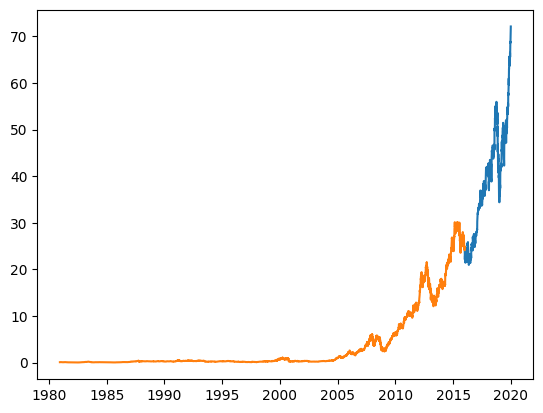

In [ ]:
# Visualizing Time Separated Data
fig, ax = plt.subplots()

ax.plot(data_val_dates)
ax.plot(data_train_dates)

In [7]:
# Transforming the data
# We first seperated the data so as to scale the training data without knowledge of validation data
# data_val will have values larger than one which is fine since the price could have risen higher than what was the previous high in the training set

scaler = MinMaxScaler(feature_range = (0,1))
data_train = scaler.fit_transform(data_train_dates.to_numpy().reshape(-1,1))
data_val = scaler.fit_transform(data_val_dates.to_numpy().reshape(-1,1))

In [8]:
# Data Preparation for RNN Predictiions
# Input to our RNN would take in a variable amount of previous records' adjusted closing prices (in this case 4(this can be changed))
# Output from our RNN would be the prediction of the next time period's adjusted closing price

def data_prep(input_data, num_prev_records):
  X = []
  Y = []

  for i in range(num_prev_records, len(input_data)):
    X.append(input_data[i-num_prev_records:i])
    Y.append(input_data[i])

  X = np.array(X)
  Y = np.array(Y)

  return X, Y

In [9]:
# Splitting Time Data into input and target sets for both training and validation data sets
input_train, target_train = data_prep(data_train, 4)
input_val, target_val = data_prep(data_val, 4)

In [ ]:
# --------Initializing Parameters for RNN Model--------
learning_rate = 0.001
num_epochs = 7  # How much training the model goes through
T = 4  # Number of records used in prediction (length of the input sequence)
num_hidden_nodes = 200  # How many hidden nodes are in the hidden layer
num_outputs = 1  # How many predictions we are making (in this case just one, the next ADJUSTED CLOSING PRICE)

# How many steps we want backpropagation instead of doing all steps (num_prev_records)
backprop_truncate = 3 # This saves computational power and trains the model faster

# This a basic solution to the exploding gradient problem
# By restricting the range of the gradients, we can prevent them from getting too large
min_grad_value = -7
max_grad_value = 7

np.random.seed(15) #for debugging

# -----------Random weight Initialization-----------
# These are the weights that are between the input and hidden layers
input_hidden_weights = np.random.uniform(0, 1, (num_hidden_nodes, T)) # also known as U
# These are the weights for the hidden layer (store the memory)
internal_hidden_weights = np.random.uniform(0, 1, (num_hidden_nodes, num_hidden_nodes)) # also known as W
# These are the weights that are between hidden and output layers
hidden_output_weights = np.random.uniform(0, 1, (num_outputs, num_hidden_nodes)) # also known as V

# Defining Activation Functions (we used sigmoid but other can be tried)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return (np.maximum(0,x))

def tanh(x):
    return np.tanh(x)

In [ ]:
# function that will perform the forward passes and calculate the loss/error
def forward_pass(input, target, total_loss):
  # do a forward pass to get prediction
  for i in range(target.shape[0]):
    x, y = input[i], target[i]
    previous_sum = np.zeros((num_hidden_nodes,1))

    for record in range(T):
      new_input = np.zeros(x.shape)
      new_input[record] = x[record]
      # Dot product of the weights that are in the RNN layer
      forward_W = np.dot(internal_hidden_weights, previous_sum)

      # Dot product of the input and the weights that are between the input and the hidden layers
      forward_U = np.dot(input_hidden_weights, new_input)

      # Sum of the previous two dot products to save the knowledge of previous timestep
      sum_of_WU = forward_W + forward_U
      activated_sum_of_WU = sigmoid(sum_of_WU) # apply our activation function to their sum (can be any activation function, we use best results one)

      # activation of values at output
      forward_V = np.dot(hidden_output_weights, activated_sum_of_WU)
      previous_sum = activated_sum_of_WU # save the currect activation sum for the next iteration

    # calculate error
    total_loss = calculate_pass_error(y, forward_V, total_loss)
  total_loss = total_loss / float(y.shape[0])

  return total_loss

def calculate_pass_error(y, forward_V, total_loss):
  single_record_loss = ((y - forward_V)**2) / 2 # (error)squared / 2
  total_loss += single_record_loss

  return total_loss

In [ ]:
# function that initializes the derivative variables that will be used in backpropagation and truncate
def init_backward_pass_der_vars(weights_arr):
  # Initialize derivative weight matrices with zeros and shape of the weight
  der_input_record_U = np.zeros(weights_arr[0].shape)
  der_internal_record_W = np.zeros(weights_arr[1].shape)
  der_output_record_V = np.zeros(weights_arr[2].shape)
  der_input_record_Ui = np.zeros(weights_arr[0].shape)
  der_internal_record_Wi = np.zeros(weights_arr[1].shape)

  # save them in an array for easier access and passing
  der_record_weights_arr = [der_input_record_U, der_internal_record_W, der_output_record_V, der_input_record_Ui, der_internal_record_Wi]

  return der_record_weights_arr

# function that will perform the backpropagation with truncate, meaning instead of doing all time steps in the RNN layer, we only backprop up to the n step
# Using truncation will save time and calculations because we wont go over every single time step
def truncate_bptt(x, record, forward_weight_arr, der_act_sum_and_forw_V, sum_of_WU, der_previous_sum, weights_arr, der_record_weights_arr, layers):
  # starting at:
  start = record - 1
  # ending at:
  end = max(-1, start - backprop_truncate)
  # step per loop
  step = -1
  for i in range(start, max(-1, end), step):
    #stores the derivative activation sum of the weights W and U
    der_act_sum_of_WU = der_act_sum_and_forw_V + der_previous_sum
    der_sum = sum_of_WU * (1 - sum_of_WU) * der_act_sum_of_WU
    # calculate the derivative of foward weight values
    der_forward_U = der_sum * np.ones_like(forward_weight_arr[0])
    der_forward_W = der_sum * np.ones_like(forward_weight_arr[1])
    der_record_weights_arr[4] = np.dot(weights_arr[1], layers[record]["previous_sum"])
    # Save the previous sum derivative
    der_previous_sum = np.dot(np.transpose(weights_arr[1]), der_forward_W)
    new_input = np.zeros(x.shape) # create an empty input array with zeros
    new_input[record] = x[record]
    der_record_weights_arr[3] = np.dot(weights_arr[0], new_input)
    # Saves the resulting derrivative
    res_der = np.dot(np.transpose(weights_arr[0]), der_forward_U)
    der_record_weights_arr[0] += der_record_weights_arr[3] # adding previous gradients on lookback
    der_record_weights_arr[1] += der_record_weights_arr[4] # adding previous gradients on lookback

  return der_record_weights_arr

def update_weights(weights_arr, learning_rate, der_weights_arr):
  weights_arr[0] -= learning_rate * der_weights_arr[0] # der_input_U
  weights_arr[1] -= learning_rate * der_weights_arr[1] # der_internal_W
  weights_arr[2] -= learning_rate * der_weights_arr[2] # der_output_V

  return weights_arr


In [ ]:
def backward_pass(x, y, weights_arr, forward_weight_arr, der_forward_V, sum_of_WU, layers):

  # initialize derivative variables for backward pass
  der_input_U = np.zeros(weights_arr[0].shape)
  der_internal_W = np.zeros(weights_arr[1].shape)
  der_output_V = np.zeros(weights_arr[2].shape)
  der_record_weights_arr = init_backward_pass_der_vars(weights_arr) # initialize der weight variables

  # ----Backpropagation-----
  for record in range(T):
      der_record_weights_arr[2] = np.dot(der_forward_V, np.transpose(layers[record]["activated_sum_of_WU"]))
      # stores the derrivative of the activated sum and the forward weight V
      der_act_sum_and_forw_V = np.dot(np.transpose(weights_arr[2]), der_forward_V)
      der_act_sum_of_WU = der_act_sum_and_forw_V
      # Stores the derrivative of the sums which will be used to calculate the forward derivative of weight W
      der_sum = sum_of_WU * (1 - sum_of_WU) * der_act_sum_of_WU
      der_forward_W = der_sum * np.ones_like(forward_weight_arr[1])
      # Saves the derivative of the sum as the previous sum to use it next iteration
      der_previous_sum = np.dot(np.transpose(weights_arr[1]), der_forward_W)

      # Backprop truncating
      der_record_weights_arr = truncate_bptt(x, record, forward_weight_arr, der_act_sum_and_forw_V, sum_of_WU, der_previous_sum, weights_arr, der_record_weights_arr, layers)

      # adding derivative weights after truncating up to n records
      der_input_U += der_record_weights_arr[0]
      der_internal_W += der_record_weights_arr[1]
      der_output_V += der_record_weights_arr[2]

      der_val_arr = [der_output_V, der_input_U, der_internal_W]

      # Constraint gradient values to prevent exploding and vanishing gradient
      # Checks if greater than max_gradient_value
      for der_val in der_val_arr:
          if der_val.max() > max_grad_value:
              der_val[der_val > max_grad_value] = max_grad_value
      # Checks if less than min_gradient_value
      for der_val in der_val_arr:
          if der_val.min() < min_grad_value:
              der_val[der_val < min_grad_value] = min_grad_value

  der_weights_arr = [der_input_U, der_internal_W, der_output_V]

  return der_weights_arr

In [ ]:
# function to train the model, does a forward pass appending activated sum of layers,
#   gets the derrivative of predictions, does backwardpassing (truncating at n value) and updates weights every loop
def train_model(input, target, weights_arr):
  for i in range(target_train.shape[0]):
    x, y = input[i], target[i]
    layers = []
    previous_sum = np.zeros((num_hidden_nodes, 1))

    # forward pass appending activated sum of layers
    for record in range(T):
      new_input = np.zeros(x.shape)
      new_input[record] = x[record]

      # Dot product of the input and the weights that are between the input and the hidden layers
      forward_U = np.dot(weights_arr[0], new_input)

      # Dot product of the weights that are in the RNN layer
      forward_W = np.dot(weights_arr[1], previous_sum)

      # Sum of the previous two dot products to save the knowledge of previous timestep
      sum_of_WU = forward_W + forward_U
      activated_sum_of_WU = sigmoid(sum_of_WU) # apply our activation function to their sum
      forward_V = np.dot(weights_arr[2], activated_sum_of_WU) # activation of values at output

      # Must save the activated sum of the current layer and previous layer's timestep
      layers.append({"activated_sum_of_WU": activated_sum_of_WU, "previous_sum": previous_sum})
      previous_sum = activated_sum_of_WU # save the currect activation sum for the next iteration

    # derivative of pred
    der_forward_V = (forward_V - y)

    # save variables for easier passing
    forward_weight_arr = [forward_U, forward_W, forward_V]

    # Backward pass
    der_weights_arr = backward_pass(x, y, weights_arr, forward_weight_arr, der_forward_V, sum_of_WU, layers)

    # update weights with gradient of weights
    weights_arr = update_weights(weights_arr, learning_rate, der_weights_arr)

In [ ]:
# Main function that calculates loss on train data, validation data, prints and plots results, and trains the data
def main():

  print("-----Initial Values-----")
  print("Learning rate: " + str(learning_rate))
  print("Number of Epochs: " + str(num_epochs))
  print("Num Input Records: " + str(T))
  print("Num Hidden Units: " + str(num_hidden_nodes))
  print("Btt Truncate: " + str(backprop_truncate))
  print("min_grad_value: " + str(min_grad_value))
  print("max_grad_value: " + str(max_grad_value))
  print("------------------------\n")

  for epoch in range(num_epochs):

    # -------Forward pass to calculate the loss/error on train-------
    # Perform a forward pass and check the total loss on train data
    total_loss = 0
    total_loss = forward_pass(input_train, target_train, total_loss)

    # -------Forward pass to calculate the loss/error on validation-------
    # Perform a forward pass and check the total loss on validation data
    total_val_loss = 0
    total_val_loss = forward_pass(input_val, target_val, total_val_loss)

    # Prints out the current epoch, the total number of epochs, the epoch loss and validation loss
    #   and also a plot of the loss for that epoch for validation data (this is interesting because we can see how it improves each epoch (or if it gets worse))
    print("----------------------Running Epoch: " + str(epoch + 1) + " out of " + str(num_epochs) + "----------------------")
    print("Epoch: ", epoch + 1, ", Train Loss: ", total_loss[0][0], ", Val Loss: ", total_val_loss[0][0] , "\n")

    # Save weights into arrays for easier variable pass
    weights_arr = [input_hidden_weights, internal_hidden_weights, hidden_output_weights]

    # -------Train model-------
    # In the model training we will have a forward pass which will calculate the loss/errors
    # Then we will do a backward pass which is used to calculate the gradients
    # After calculating we update them and this will repeat
    train_model(input_train, target_train, weights_arr)

  print("\n---------------------------------DONE--------------------------------")

In [ ]:
main()

-----Initial Values-----
Learning rate: 0.001
Number of Epochs: 7
Num Input Records: 4
Num Hidden Units: 200
Btt Truncate: 3
min_grad_value: -7
max_grad_value: 7
------------------------

----------------------Running Epoch: 1 out of 7----------------------
Epoch:  1 , Train Loss:  43023543.17578008 , Val Loss:  4854562.3110323455 

----------------------Running Epoch: 2 out of 7----------------------
Epoch:  2 , Train Loss:  7926.861186125432 , Val Loss:  429.52718701479296 

----------------------Running Epoch: 3 out of 7----------------------
Epoch:  3 , Train Loss:  7893.296090236908 , Val Loss:  427.65428590550573 

----------------------Running Epoch: 4 out of 7----------------------
Epoch:  4 , Train Loss:  7857.62455751313 , Val Loss:  425.6775007041105 

----------------------Running Epoch: 5 out of 7----------------------
Epoch:  5 , Train Loss:  7822.300931557182 , Val Loss:  423.7210800258284 

----------------------Running Epoch: 6 out of 7----------------------
Epoch:  6 

In [ ]:
# function to do a foward pass using the trained weights so that we can get the predictions and plot them against real data
def plot_with_trained_weights(input, target):
  predictions_arr = []
  for i in range(target.shape[0]):
      x, y = input[i], target[i]
      previous_sum = np.zeros((num_hidden_nodes, 1))
      # Forward pass
      for record in range(T):
        new_input = np.zeros(x.shape)
        new_input[record] = x[record]
        # Dot product of the weights that are in the RNN layer
        forward_W = np.dot(internal_hidden_weights, previous_sum)
        # Dot product of the input and the weights that are between the input and the hidden layers
        forward_U = np.dot(input_hidden_weights, x)
        # Sum of the previous two dot products to save the knowledge of previous timestep
        sum_of_WU = forward_W + forward_U
        activated_sum_of_WU = sigmoid(sum_of_WU) # apply our activation function to their sum
         # activation of values at output
        forward_V = np.dot(hidden_output_weights, activated_sum_of_WU)
        previous_sum = activated_sum_of_WU # save the currect activation sum for the next iteration

      predictions_arr.append(forward_V) # Append to the prediction array so we can plot the predictions

  predictions_arr = np.array(predictions_arr)

  #Normalized the predictions
  normed_predictions_arr= (predictions_arr-np.min(predictions_arr))/(np.max(predictions_arr)-np.min(predictions_arr))

  # Scale back from 0-1 to Adjusted Stock Price in USD
  target_USD = scaler.inverse_transform(target)
  normed_predictions_arr_USD = scaler.inverse_transform(normed_predictions_arr.reshape(-1,1))


  # Create data Dataframe for plotting validation data
  val_df_dates = pd.DataFrame(data_val_dates.index)
  val_df_dates = val_df_dates.loc[4:]


  # plotting
  plt.plot(val_df_dates,target_USD[:, 0], "r", label = "Actual Stock Prices")
  plt.plot(val_df_dates,normed_predictions_arr_USD[:, 0], "g", label = "Stock Price Predictions")
  plt.gca().xaxis.set_major_locator(mdates.YearLocator())
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
  plt.ylabel("Adjusted Stock Price (USD)")
  plt.title("Custom Model")
  fig.set_size_inches(10, 6)
  plt.legend()
  plt.show()

  rmse = mean_squared_error(target_USD[:, 0], normed_predictions_arr_USD[:, 0], squared = False)
  print("RMSE: " + str(rmse))

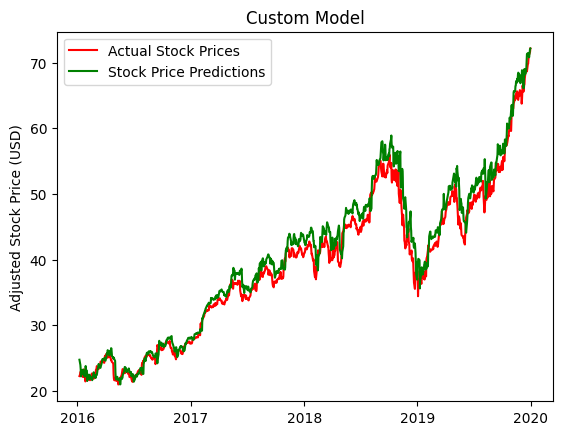

RMSE: 2.084803968588898


In [ ]:
# Check model predictions against acutal stock prices using validation data set
plot_with_trained_weights(input_val,target_val)

In [10]:
# Use Keras to create a comparalbe RNN to the one manually implemented above
from keras.models import Sequential
from keras.layers import SimpleRNN,Dense

# Number of previous time steps used as input variables to predict the next time step
look_back = 4

# Create new data sets for Keras Model
input_train_K, target_train_K = data_prep(data_train, look_back)
input_val_K, target_val_K = data_prep(data_val, look_back)


In [12]:
# Building Keras RNN Model
keras_RNN = Sequential()

keras_RNN.add(SimpleRNN(units = 200,
                        activation = "sigmoid",
                        return_sequences = True,
                        input_shape = (input_train_K.shape[1],1)))

keras_RNN.add(Dense(1))

keras_RNN.compile(
    optimizer = "adam",
    loss = "mean_squared_error",
    metrics = ["mse"])

In [14]:
# Building Keras RNN Model
keras_RNN = Sequential()

keras_RNN.add(SimpleRNN(units = 200,
                        activation = "sigmoid",
                        return_sequences = True,
                        input_shape = (input_train_K.shape[1],1)))

keras_RNN.add(Dense(1))

keras_RNN.compile(
    optimizer = "adam",
    loss = "mean_squared_error",
    metrics = ["mse"])

In [25]:
#Fitting Model
history = keras_RNN.fit(input_train_K, target_train_K, epochs=10, batch_size= 32, validation_data=(input_val_K, target_val_K))

Epoch 1/10
277/277 [==============================] - 2s 7ms/step - loss: 1.0457e-04 - mse: 1.0457e-04 - val_loss: 3.8673e-04 - val_mse: 3.8673e-04
Epoch 2/10
277/277 [==============================] - 2s 8ms/step - loss: 9.8391e-05 - mse: 9.8391e-05 - val_loss: 4.6610e-04 - val_mse: 4.6610e-04
Epoch 3/10
277/277 [==============================] - 2s 6ms/step - loss: 9.0378e-05 - mse: 9.0378e-05 - val_loss: 3.6805e-04 - val_mse: 3.6805e-04
Epoch 4/10
277/277 [==============================] - 2s 6ms/step - loss: 8.9441e-05 - mse: 8.9441e-05 - val_loss: 3.6960e-04 - val_mse: 3.6960e-04
Epoch 5/10
277/277 [==============================] - 2s 7ms/step - loss: 7.8558e-05 - mse: 7.8558e-05 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 6/10
277/277 [==============================] - 2s 8ms/step - loss: 1.0775e-04 - mse: 1.0775e-04 - val_loss: 4.0495e-04 - val_mse: 4.0495e-04
Epoch 7/10
277/277 [==============================] - 2s 6ms/step - loss: 8.9878e-05 - mse: 8.9878e-05 - val_loss: 4.032

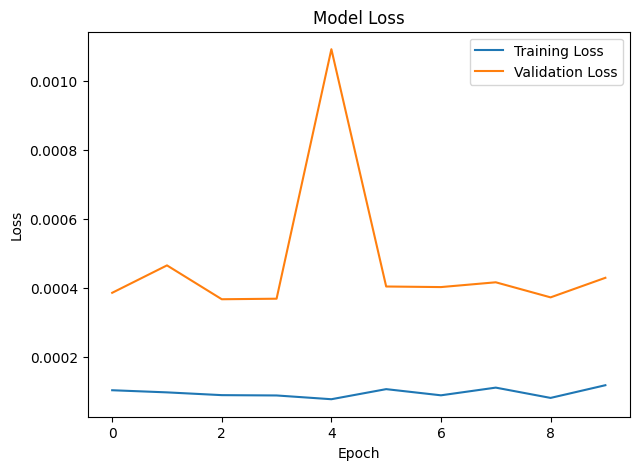

In [26]:
# Plot loss and accuracy during training
plt.figure(figsize=(7, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

32/32 [==============================] - 0s 2ms/step


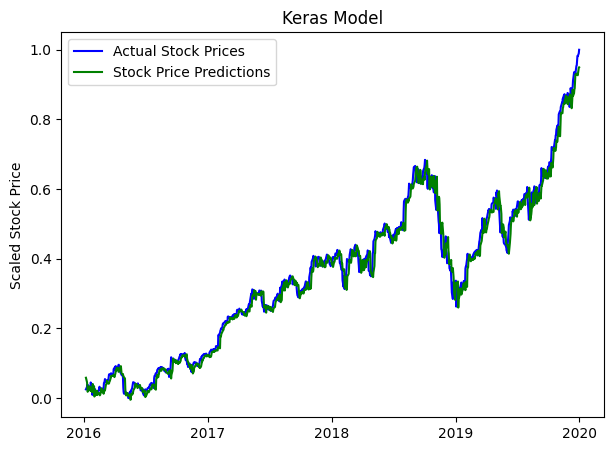

RMSE: 0.024653833212560677


In [27]:
# Predict Validation and plot the comparison of real data from validation set and prediciton
keras_pred = keras_RNN.predict(input_val_K)


# Create data Dataframe for plotting validation data
val_df_dates = pd.DataFrame(data_val_dates.index)
val_df_dates = val_df_dates.loc[4:]


# plotting
plt.figure(figsize = (7,5))
plt.plot(val_df_dates,target_val_K[:,0], "b", label = "Actual Stock Prices")
plt.plot(val_df_dates,keras_pred[:,0][:, 0], "g", label = "Stock Price Predictions")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
plt.ylabel("Scaled Stock Price")
plt.title("Keras Model")
plt.legend()
plt.show()
rmse = mean_squared_error(target_val_K[:,0], keras_pred[:,0], squared = False)
print("RMSE: " + str(rmse))